# Sentiment Analysis: (summary_plot dataset)  +
# linear regression on summary positive and negative words percentages and movie runtime
Tokinize summaries, remove stopwords and calculate the persentage of words, after calssifying them among neutral, positive or negative to finally find the ratio between the percentage of positive words over percentage of negative words for each movie summary.

In [128]:
#imports, data folders and necessary requirements
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sn

import os
import json
from sklearn import preprocessing

!pip install --user -U nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.util import *

!pip install -U textblob
from textblob import TextBlob

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"

[nltk_data] Downloading package punkt to /Users/ahmedaziz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedaziz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [129]:
#extract dataset and create a copy for later use
summary_file_name = os.path.join(PATH_FOLDER, 'plot_summaries.txt')
summary_metadata_original = pd.read_csv(summary_file_name,  sep="\t")
summary_metadata_original.columns =["Movie ID", "Movie Summary"]

summary_metadata_original["Movie Summary"] = summary_metadata_original["Movie Summary"].astype("string")

summary_metadata = summary_metadata_original.copy()
summary_metadata_original.shape

(42302, 2)

In [130]:
#Extract each column in a new Series variables
Movie_IDs = summary_metadata["Movie ID"].squeeze()
Movie_Summaries = summary_metadata["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
summary_metadata = summary_metadata.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

0
8
(42294, 2)


In [131]:
#function used to tokenize into dataframe columns into single words
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens.

    Args:
        column: Pandas dataframe column.

    Returns:
        tokens (list): Tokenized list.
    """

    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 

In [132]:
#add a column containing tokenized summaries
summary_metadata['tokenized_summary'] = summary_metadata.apply(lambda x: tokenize(x['Movie Summary']), axis=1)

summary_metadata

,Movie ID,Movie Summary,tokenized_summary
0,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal..."
1,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si..."
2,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw..."
3,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla..."
4,5272176,The president is on his way to give a speech. ...,"[The, president, is, on, his, way, to, give, a..."
...,...,...,...
42297,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli..."
42298,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks..."
42299,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson..."
42300,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f..."


In [133]:
#filter the column containing tokenized text by deleting all stopwords
summary_metadata['filtered_Tokens'] = summary_metadata['tokenized_summary'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

summary_metadata

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens
0,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw..."
1,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,..."
2,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ..."
3,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla..."
4,5272176,The president is on his way to give a speech. ...,"[The, president, is, on, his, way, to, give, a...","[president, way, give, speech, traveling, man,..."
...,...,...,...,...
42297,34808485,"The story is about Reema , a young Muslim scho...","[The, story, is, about, Reema, a, young, Musli...","[story, Reema, young, Muslim, schoolgirl, Mala..."
42298,1096473,"In 1928 Hollywood, director Leo Andreyev look...","[In, Hollywood, director, Leo, Andreyev, looks...","[Hollywood, director, Leo, Andreyev, looks, ph..."
42299,35102018,American Luthier focuses on Randy Parsons’ tra...,"[American, Luthier, focuses, on, Randy, Parson...","[American, Luthier, focuses, Randy, Parsons, t..."
42300,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...","[Abdur, Rehman, Khan, a, dry, fruit, seller, f...","[Abdur, Rehman, Khan, dry, fruit, seller, Afgh..."


In [134]:
#Initialize an empty list to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column 
positive_scores = []
negative_scores = []
neutral_scores = []
sentiment_scores = []

#Perform sentiment analysis on each word
for liss in summary_metadata['filtered_Tokens'][:] :
  nbr_words_pos = 0
  nbr_words_neg = 0
  nbr_words_neu = 0
  nbr_words = 0

  for word in liss:
    nbr_words+= 1
    blob = TextBlob(word)
    #perform sentiment polarities of the word
    if (blob.sentiment.polarity > 0):
        nbr_words_pos += 1
    elif (blob.sentiment.polarity < 0):
        nbr_words_neg += 1
    else:
        nbr_words_neu += 1
    
  positive_scores.append(nbr_words_pos/nbr_words * 100)
  negative_scores.append(nbr_words_neg/nbr_words * 100)
  neutral_scores.append(nbr_words_neu/nbr_words * 100)

In [186]:
#create columns to store percentage of positive, negative and neutral words in each row of the 'filtered_Tokens' column
summary_metadata["percentage of positive words"] = positive_scores
summary_metadata["percentage of negative words"] = negative_scores
summary_metadata["percentage of neutral words"] = neutral_scores
summary_metadata.head(5)

,Movie ID,Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words,ratio pos/neg words
0,31186339,The nation of Panem consists of a wealthy Capi...,"[The, nation, of, Panem, consists, of, a, weal...","[nation, Panem, consists, wealthy, Capitol, tw...",3.729604,2.797203,93.473193,1.333333
1,20663735,Poovalli Induchoodan is sentenced for six yea...,"[Poovalli, Induchoodan, is, sentenced, for, si...","[Poovalli, Induchoodan, sentenced, six, years,...",4.609929,4.609929,90.780142,1.000000
2,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The, Lemon, Drop, Kid, a, New, York, City, sw...","[Lemon, Drop, Kid, New, York, City, swindler, ...",6.126915,4.157549,89.715536,1.473684
3,595909,Seventh-day Adventist Church pastor Michael Ch...,"[Adventist, Church, pastor, Michael, Chamberla...","[Adventist, Church, pastor, Michael, Chamberla...",5.472637,3.980100,90.547264,1.375000
4,5272176,The president is on his way to give a speech. ...,"[The, president, is, on, his, way, to, give, a...","[president, way, give, speech, traveling, man,...",2.139037,5.882353,91.978610,0.363636


In [149]:
#movie dataset
movie_file_name = os.path.join(PATH_FOLDER, 'movie.metadata.tsv')
names_2 = ["Movie ID", 
            "Freebase movie ID", 
            "Movie name", 
            "Movie release date", 
            "Movie box office revenue", 
            "Movie runtime", 
            "Movie languages (Freebase ID:name tuples)",
            "Movie countries (Freebase ID:name tuples)", 
            "Movie genres (Freebase ID:name tuples)"]

movie_metadata = pd.read_csv(movie_file_name,  sep="\t", names = names_2)

In [168]:
# Merge the dataframes based on the "Wikipedia movie ID"
movie_summary_metadata = pd.merge(movie_metadata, summary_metadata, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(5)

,Movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie Summary,tokenized_summary,filtered_Tokens,percentage of positive words,percentage of negative words,percentage of neutral words,ratio pos/neg words
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, century,...","[Set, second, half, century, film, depicts, Ma...",1.515152,5.555556,92.929293,0.272727
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,"[Finally, negotiations, are, made, for, Henry,...","[Finally, negotiations, made, Henry, named, ki...",0.000000,3.030303,96.969697,0.000000
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,"[The, film, opens, with, Mary, Poppins, perche...","[film, opens, Mary, Poppins, perched, cloud, h...",4.509284,2.519894,92.970822,1.789474
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",A young 20-year-old named Jody lives with his...,"[A, young, named, Jody, lives, with, his, moth...","[young, named, Jody, lives, mother, Juanita, a...",5.167173,2.431611,92.401216,2.125000
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,"[The, film, is, a, collision, of, three, separ...","[film, collision, three, separate, journey, Bu...",2.758621,2.413793,94.827586,1.142857


In [169]:
#Function to split data between train and test
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [188]:
#Dataframe containing only the used features and the output
reduced_dataf = movie_summary_metadata[['Movie runtime', "percentage of positive words", "percentage of negative words", 'Movie box office revenue']]

[train, test] = split_set(reduced_dataf)

#X_train, y_train, X_test and y_test
train_label=train["Movie box office revenue"]
train_features = train.drop("Movie box office revenue", axis=1)
test_label=test["Movie box office revenue"]
test_features = test.drop("Movie box office revenue", axis=1)

In [191]:
#standerdize train and test features
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    if (stddevs[c] != 0):
        train_features_std[c] = (train_features[c]-means[c])/stddevs[c] 

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    if (stddevs[c] != 0):
        test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

In [192]:
from sklearn.linear_model import LinearRegression

#train a linear regression model
model = LinearRegression()
model.fit(train_features_std,train_label)

LinearRegression()

In [194]:
from sklearn.metrics import mean_squared_error

#prediction on test features
prediction = model.predict(test_features_std)

#Evaluate the model
mse = mean_squared_error(test_label, prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 9364279216990128.0


In [195]:
# Get the coefficients
coefficients = model.coef_

# Get the intercept
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 24198265.84204919 -13464058.71641275  -5519868.71227576]
Intercept: 53627432.489200145


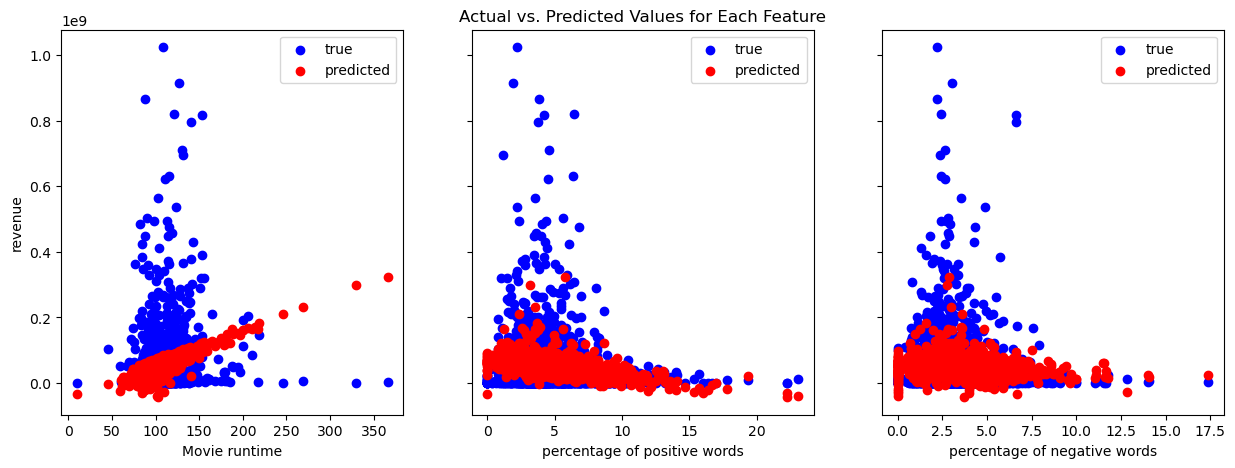

In [199]:
# Plot actual vs. predicted values for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, feature in enumerate(['Movie runtime', "percentage of positive words", "percentage of negative words"]):
    axes[i].scatter(test_features[feature], test_label, color='blue', label='true')
    axes[i].scatter(test_features[feature], prediction, color='red', label='predicted')
    axes[i].set_xlabel(feature)
    axes[i].legend()

axes[0].set_ylabel('revenue')
axes[1].set_title('Actual vs. Predicted Values for Each Feature')

plt.show()

# Named Entity Recognition (NER): (summary_plot dataset) +
# linear regression on summary score and movie runtime

Use spaCy NLP library to perform Named Entity Recognition on the movie summaries.
Extract entities and their categories (e.g., PERSON, GPE, ORGANIZATION).
Count the occurrences of different types of entities in successful and less successful movies.

In [101]:
#extract dataset and create a copy for later use
summary_file_name = os.path.join(PATH_FOLDER, 'plot_summaries.txt')
summary_metadata_original = pd.read_csv(summary_file_name,  sep="\t")
summary_metadata_original.columns =["Movie ID", "Movie Summary"]

summary_metadata_original["Movie Summary"] = summary_metadata_original["Movie Summary"].astype("string")

summary_metadata = summary_metadata_original.copy()
summary_metadata_original.shape

(42302, 2)

In [102]:
#Extract each column in a new Series variables
Movie_IDs = summary_metadata["Movie ID"].squeeze()
Movie_Summaries = summary_metadata["Movie Summary"].squeeze()

#Check uniqueness of values in each Series variable
print(Movie_IDs.duplicated().sum()) # contains 0 duplicate values
print(Movie_Summaries.duplicated().sum()) # contains 8 duplicate values

#Remove duplicate values
summary_metadata = summary_metadata.drop_duplicates("Movie Summary")
print(summary_metadata.shape)

0
8
(42294, 2)


In [103]:
! pip install spacy
!python -m spacy download en_core_web_sm

#imports, data folders and necessary requirements
import spacy
from spacy.lang.en.examples import sentences
from collections import Counter

#Load the spaCy English model
nlp = spacy.load("en_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Creating a single number based on the occurrences of different entity types for each movie summary:                      

 Score = PERSON + ORG + GPE + LOC + 0.5×(DATE + MONEY + TIME + PERCENT + QUANTITY + ORDINAL + CARDINAL)

In [106]:
#List of entity types and weights (weights are chosen manually)
entity_weights = {
    "PERSON": 1,
    "ORG": 1,
    "GPE": 1,
    "LOC": 1,
    "DATE": 0.5,
    "TIME": 0.5,
    "MONEY": 0.5,
    "PERCENT": 0.5,
    "QUANTITY": 0.5,
    "ORDINAL": 0.5,
    "CARDINAL": 0.5
}

#Function to calculate the score for a summary
def calculate_score(summary):
    doc = nlp(summary)
    
    # Calculate entity occurrences for each sentence
    sentence_scores = []
    for sentence in doc.sents:
        entity_counts = Counter([ent.label_ for ent in sentence.ents])
        sentence_score = sum(entity_counts.get(entity, 0) * weight for entity, weight in entity_weights.items())
        sentence_scores.append(sentence_score)
    #mean over scores of all sentences of each movie summary
    return np.mean(sentence_scores)

#Add a new column 'Scores' to the DataFrame
summary_metadata['Scores'] = summary_metadata["Movie Summary"].apply(calculate_score)

#Print the resulting DataFrame
summary_metadata


,Movie ID,Movie Summary,Scores
0,31186339,The nation of Panem consists of a wealthy Capi...,1.240385
1,20663735,Poovalli Induchoodan is sentenced for six yea...,2.230769
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",1.183673
3,595909,Seventh-day Adventist Church pastor Michael Ch...,1.633333
4,5272176,The president is on his way to give a speech. ...,1.462963
...,...,...,...
42297,34808485,"The story is about Reema , a young Muslim scho...",1.500000
42298,1096473,"In 1928 Hollywood, director Leo Andreyev look...",0.854839
42299,35102018,American Luthier focuses on Randy Parsons’ tra...,0.916667
42300,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",2.050000


In [116]:
#movie dataset
movie_file_name = os.path.join(PATH_FOLDER, 'movie.metadata.tsv')
names_2 = ["Movie ID", 
            "Freebase movie ID", 
            "Movie name", 
            "Movie release date", 
            "Movie box office revenue", 
            "Movie runtime", 
            "Movie languages (Freebase ID:name tuples)",
            "Movie countries (Freebase ID:name tuples)", 
            "Movie genres (Freebase ID:name tuples)"]

movie_metadata = pd.read_csv(movie_file_name,  sep="\t", names = names_2)

In [118]:
# Merge the dataframes based on the "Wikipedia movie ID"
movie_summary_metadata = pd.merge(movie_metadata, summary_metadata, on="Movie ID", how='outer')

# Drop NAN values
movie_summary_metadata.dropna(inplace=True)

movie_summary_metadata.head(5)

,Movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie Summary,Scores
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th...",1.266667
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,2.166667
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",The film opens with Mary Poppins perched in a...,1.773438
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",A young 20-year-old named Jody lives with his...,2.013158
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980,34331783.0,109.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/0hzlz"": ""South Africa""}","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",The film is a collision of three separate stor...,1.613636


In [119]:
#Function to split data between train and test
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [120]:
#Dataframe containing only the used features and the output
reduced_dataf = movie_summary_metadata[['Movie runtime', 'Scores', 'Movie box office revenue']]

[train, test] = split_set(reduced_dataf)

#X_train, y_train, X_test and y_test
train_label=train["Movie box office revenue"]
train_features = train.drop("Movie box office revenue", axis=1)
test_label=test["Movie box office revenue"]
test_features = test.drop("Movie box office revenue", axis=1)

In [121]:
#standerdize train and test features
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

In [124]:
from sklearn.linear_model import LinearRegression

#train a linear regression model
model = LinearRegression()
model.fit(train_features_std,train_label)

LinearRegression()

In [125]:
from sklearn.metrics import mean_squared_error

#prediction on test features
prediction = model.predict(test_features_std)

#Evaluate the model
mse = mean_squared_error(test_label, prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.2966234617104756e+16


In [126]:
# Get the coefficients
coefficients = model.coef_

# Get the intercept
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [25294287.05613805 16930330.20911274]
Intercept: 53157130.18404395


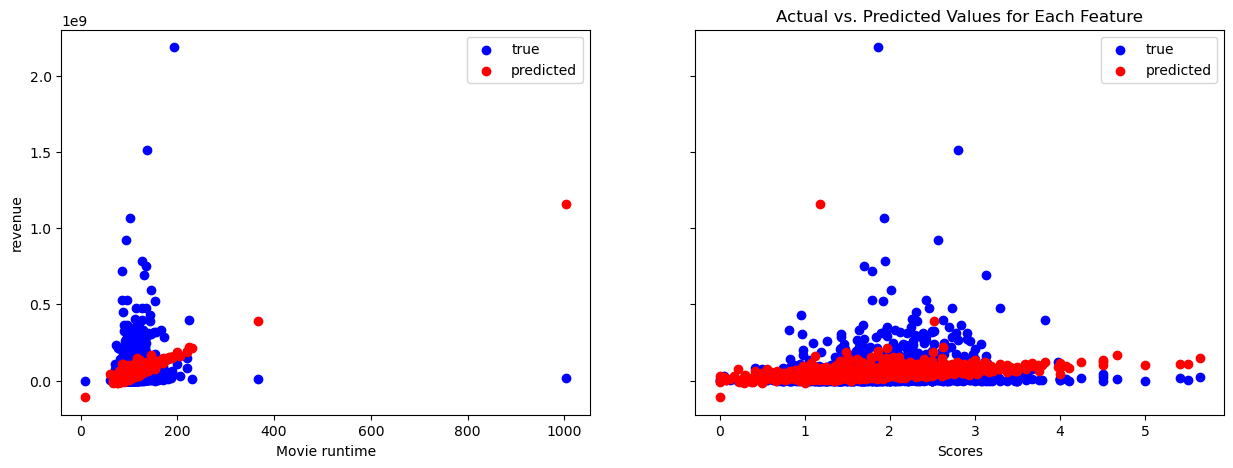

In [127]:
# Plot actual vs. predicted values for each feature
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for i, feature in enumerate(['Movie runtime', 'Scores']):
    axes[i].scatter(test_features[feature], test_label, color='blue', label='true')
    axes[i].scatter(test_features[feature], prediction, color='red', label='predicted')
    axes[i].set_xlabel(feature)
    axes[i].legend()

axes[0].set_ylabel('revenue')
axes[1].set_title('Actual vs. Predicted Values for Each Feature')

plt.show()

# Linear regression on actor gender/movie runtime/actor age at movie release

In [26]:
#character dataset
character_file_name = os.path.join(PATH_FOLDER, 'character.metadata.tsv')
names_1 = ["Wikipedia movie ID",
            "Freebase movie ID", 
            "Movie release date", 
            "Character name", 
            "Actor date of birth", 
            "Actor gender", 
            "Actor height (in meters)", 
            "Actor ethnicity (Freebase ID)",
            "Actor name", 
            "Actor age at movie release", 
            "Freebase character/actor map ID", 
            "Freebase character ID",
            "Freebase actor ID"]

character_metadata = pd.read_csv(character_file_name,  sep="\t", names= names_1)

In [27]:
#movie dataset
movie_file_name = os.path.join(PATH_FOLDER, 'movie.metadata.tsv')
names_2 = ["Wikipedia movie ID", 
            "Freebase movie ID", 
            "Movie name", 
            "Movie release date", 
            "Movie box office revenue", 
            "Movie runtime", 
            "Movie languages (Freebase ID:name tuples)",
            "Movie countries (Freebase ID:name tuples)", 
            "Movie genres (Freebase ID:name tuples)"]

movie_metadata = pd.read_csv(movie_file_name,  sep="\t", names = names_2)

In [28]:
# Merge the dataframes based on the "Freebase movie ID"
movie_character_metadata = pd.merge(movie_metadata, character_metadata, on="Freebase movie ID", how='outer')

# Drop NAN values
movie_character_metadata.dropna(inplace=True)

movie_character_metadata

,Wikipedia movie ID_x,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Wikipedia movie ID_y,...,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",975900.0,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",975900.0,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",975900.0,...,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
51,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",10408933.0,...,Roger Grant AKA Alexander,1914-05-05,M,1.820,/m/06v41q,Tyrone Power,24.0,/m/02vbvj2,/m/0h36wrs,/m/02s58t
73,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",171005.0,...,Henry V,1960-12-10,M,1.770,/m/0d7wh,Kenneth Branagh,28.0,/m/0jzbqf,/m/02nw8cd,/m/0prjs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467983,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",1918494.0,...,Joseph Turner White,1967-07-23,M,1.770,/m/033tf_,Philip Seymour Hoffman,33.0,/m/0k3rx4,/m/0bvptkd,/m/02qgqt
467984,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",1918494.0,...,Bob Barrenger,1958-04-03,M,1.800,/m/09vc4s,Alec Baldwin,42.0,/m/0k3rw_,/m/0bvptk4,/m/018ygt
467985,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",1918494.0,...,Claire Wellesley,1965-03-25,F,1.600,/m/041rx,Sarah Jessica Parker,35.0,/m/0k3rxg,/m/04fgy16,/m/0m66w
467986,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...",1918494.0,...,Marty Rossen,1954-08-30,M,1.700,/m/041rx,David Paymer,45.0,/m/02tb6rh,/m/0bvptjy,/m/02t_vx


In [29]:
#Function to split data between train and test
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [51]:
le = preprocessing.LabelEncoder()

#Encode gender
le.fit(movie_character_metadata['Actor gender'])
movie_character_metadata['Actor gender']= le.transform(movie_character_metadata['Actor gender'])

#Dataframe containing only the used features and the output
reduced_df = movie_character_metadata[['Movie runtime', 'Actor gender', 'Actor age at movie release', 'Movie box office revenue']]

[train, test] = split_set(reduced_df)

#X_train, y_train, X_test and y_test
train_label=train["Movie box office revenue"]
train_features = train.drop("Movie box office revenue", axis=1)
test_label=test["Movie box office revenue"]
test_features = test.drop("Movie box office revenue", axis=1)

In [66]:
#standerdize train and test features
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Use the mean and stddev of the training set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

In [67]:
from sklearn.linear_model import LinearRegression

#train a linear regression model
model = LinearRegression()
model.fit(train_features_std,train_label)

LinearRegression()

In [99]:
from sklearn.metrics import mean_squared_error

#prediction on test features
prediction = model.predict(test_features_std)

#Evaluate the model
mse = mean_squared_error(test_label, prediction)
print("Mean Squared Error:", mse)

Mean Squared Error: 3.2934238968001996e+16


In [ ]:
# Get the coefficients
coefficients = model.coef_

# Get the intercept
intercept = model.intercept_

# Print or use the coefficients and intercept as needed
print("Coefficients:", coefficients)
print("Intercept:", intercept)

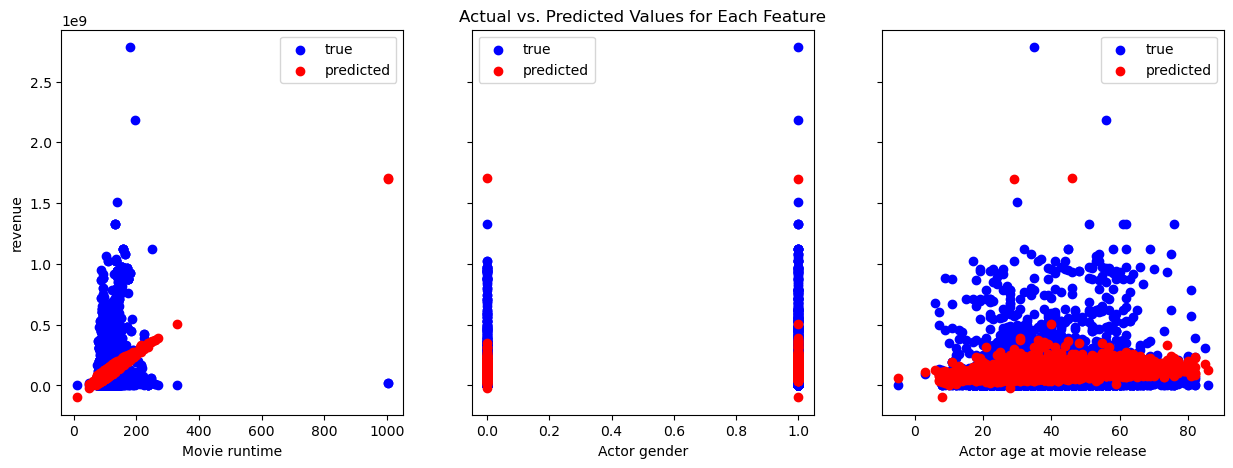

In [98]:
# Plot actual vs. predicted values for each feature
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, feature in enumerate(['Movie runtime', 'Actor gender', 'Actor age at movie release']):
    axes[i].scatter(test_features[feature], test_label, color='blue', label='true')
    axes[i].scatter(test_features[feature], prediction, color='red', label='predicted')
    axes[i].set_xlabel(feature)
    axes[i].legend()

axes[0].set_ylabel('revenue')
axes[1].set_title('Actual vs. Predicted Values for Each Feature')

plt.show()